# Task 2

In [216]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import random
from sklearn import preprocessing


# Obtaining and normalizing MNIST dataset helped by: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
# Mean and Standart Deviation 0.5 each for data normalization [-1, 1] 
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),

                               ])
# No normalization
transform2 = transforms.ToTensor()

batch_size = 10000

trainset = datasets.MNIST('', download=True, train=True, transform=transform)
valset = datasets.MNIST('', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images, labels_ = dataiter.next()

testiter = iter(valloader)
images1, labels1 = testiter.next()

# Turning the dataset into batch size of flattened 28*28 pixels
# And one hot encoding for the labels

x_train = images.numpy()
x_train = np.reshape(x_train, (batch_size,28*28))
labels = labels_.numpy()
labels = labels.reshape(-1, 1)
ohe = preprocessing.OneHotEncoder()
ohe.fit(labels)
y_train = ohe.transform(labels).toarray()



x_test = images1.numpy()
x_test = np.reshape(x_test, (batch_size,28*28))
labels1 = labels1.numpy()
labels1 = labels1.reshape(-1, 1)
ohe.fit(labels1)
y_test = ohe.transform(labels1).toarray()



#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')






class NeuralNetwork:
    def __init__(self, lr, units1, units2, layer1, layer2):
        self.train_loss = [] # list to store losses
        
        if (layer1 == "sigmoid"):
            self.layer1_feedforward_activation = self.sigmoid
            self.layer1_backward_activation = self.sigmoid_derivative
        else:
            self.layer1_feedforward_activation = self.relu
            self.layer1_backward_activation = self.relu_derivative
        if (layer2 == "sigmoid"):
            self.layer2_feedforward_activation = self.sigmoid
            self.layer2_backward_activation = self.sigmoid_derivative
        else:
            self.layer2_feedforward_activation = self.relu
            self.layer2_backward_activation = self.relu_derivative
        
        
        
        self.lr = lr
        self.units1 = units1
        self.units2 = units2
        
        
        self.wih = np.random.normal(0.0, pow(784, -0.5), (784 , self.units1))
        self.whh = np.random.normal(0.0, pow(self.units1, -0.5), (self.units1, self.units2))
        self.who = np.random.normal(0.0, pow(self.units2, -0.5), (self.units2, 10))
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
        
    
    def sigmoid_derivative(self, x):
        return x * (1-x)
    
    def relu(self, x):
        x = np.maximum(0,x)
        return x

    def relu_derivative(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    

    #def softmax(self, x):
     #   e = np.exp(x - x.max())
      #  return e / e.sum()
    
    # Taken from https://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/
    def softmax(self, s):
        exps = np.exp(s - np.max(s, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)
    
    
    
        # Cross entropy cost funtion
        # Got from the internet, couldn't find the source after
    def error(self, pred, real):
        n_samples = real.shape[0]   # No. of rows in data
        logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
        loss = np.sum(logp)/n_samples

        return loss
    
        # use to calculation errors (y - y predicted)
    def cross_entropy(self, pred, real):
        res = pred - real
        return res
    
    def train(self, inputs, targets):
               
        # Feedforward
        hidden_inputs_1 = np.dot(inputs,self.wih)  
        hidden_outputs_1 = self.layer1_feedforward_activation(hidden_inputs_1)

        hidden_inputs_2 = np.dot(hidden_outputs_1,self.whh)
        hidden_outputs_2 = self.layer2_feedforward_activation(hidden_inputs_2)


        final_inputs = np.dot(hidden_outputs_2,self.who)
        final_outputs = self.softmax(final_inputs)

        output_errors = self.error(final_outputs,targets)
        
        #print("Loss Train : ", output_errors)
        self.train_loss.append(output_errors)
        
        # Backpropagation

        who_delta = self.cross_entropy(final_outputs,targets) # W3
        final_inputs_delta =  np.dot(who_delta, self.who.T)

        whh_delta = final_inputs_delta  * self.layer2_backward_activation(hidden_outputs_2) # w2
        hidden_inputs_2_delta = np.dot(whh_delta, self.whh.T)

        whi_delta = hidden_inputs_2_delta * self.layer1_backward_activation(hidden_outputs_1) # w1
        
        
        # Weights updates 

        self.who -= self.lr * np.dot(hidden_outputs_2.T, who_delta)
        self.whh -= self.lr * np.dot(hidden_outputs_1.T, whh_delta)
        self.wih -= self.lr * np.dot(inputs.T, whi_delta)
        
        return output_errors
    
    def validate(self, inputs, targets):
        hidden_inputs_1 = np.dot(inputs,self.wih)  
        hidden_outputs_1 = self.layer1_feedforward_activation(hidden_inputs_1)

        hidden_inputs_2 = np.dot(hidden_outputs_1,self.whh)
        hidden_outputs_2 = self.layer2_feedforward_activation(hidden_inputs_2)


        final_inputs = np.dot(hidden_outputs_2,self.who)
        final_outputs = self.softmax(final_inputs)

        output_errors = self.error(final_outputs,targets)
        
        return output_errors
        
    def accuracy(self, X, Y):
        acc = []
        Y_p = self.query(X)
        for y,y_p in zip(Y,Y_p):
            if np.argmax(y) == np.argmax(y_p):
                acc.append(1)
            else:
                acc.append(0)
        return (acc.count(1)/len(acc))*100
        
    def query(self, inputs):
        inputs

        hidden_inputs_1 = np.dot(inputs,self.wih)  
        hidden_outputs_1 = self.layer1_feedforward_activation(hidden_inputs_1)

        hidden_inputs_2 = np.dot(hidden_outputs_1,self.whh)
        hidden_outputs_2 = self.layer2_feedforward_activation(hidden_inputs_2)


        final_inputs = np.dot(hidden_outputs_2,self.who)
        final_outputs = self.softmax(final_inputs)        
        return final_outputs
        
   
    
   

    

    
    


 
    
    









Training loss:  1.633645313391506
Testing loss:  1.6292350439407846
No. of epochs  1
Training loss:  0.8204448376662751
Testing loss:  0.8143812189491515
No. of epochs  2
Training loss:  0.5715395595110391
Testing loss:  0.56773867534821
No. of epochs  3
Training loss:  0.47225660147140036
Testing loss:  0.47134167265023635
No. of epochs  4
Training loss:  0.41889899824997845
Testing loss:  0.42137949442935024
No. of epochs  5
Test accuracy:  88.78


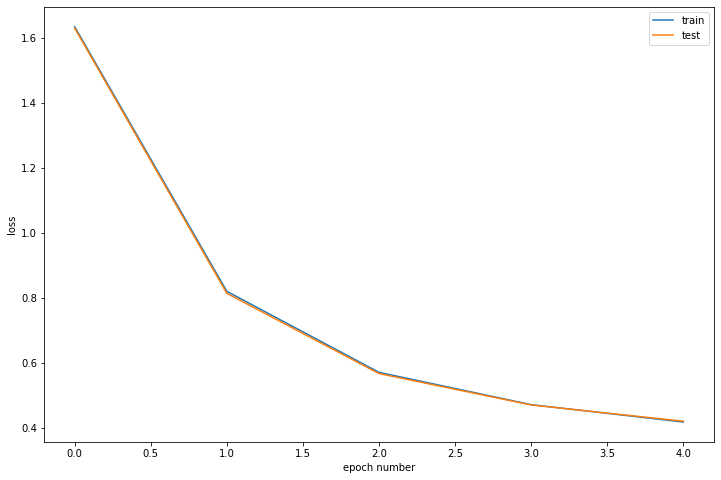

Training loss:  0.6818770560842519
Testing loss:  0.6708942781395278
No. of epochs  1
Training loss:  0.3443979150617136
Testing loss:  0.3607973931979178
No. of epochs  2
Training loss:  0.2736995767145313
Testing loss:  0.311112313594021
No. of epochs  3
Training loss:  0.22440717582275746
Testing loss:  0.28003945611356296
No. of epochs  4
Training loss:  0.1876672578165318
Testing loss:  0.2585562938012318
No. of epochs  5
Test accuracy:  92.25


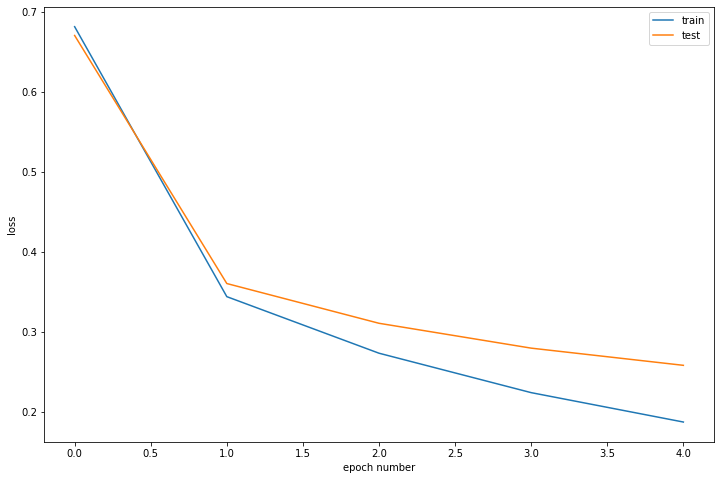

Training loss:  1.4828206317906445
Testing loss:  1.4804490927619671
No. of epochs  1
Training loss:  1.0386239945897728
Testing loss:  1.0268445669530426
No. of epochs  2
Training loss:  0.8915457742788776
Testing loss:  0.883313877393956
No. of epochs  3
Training loss:  0.808247648574085
Testing loss:  0.8163239467034756
No. of epochs  4
Training loss:  0.758540930270348
Testing loss:  0.7810393229697377
No. of epochs  5
Test accuracy:  77.7


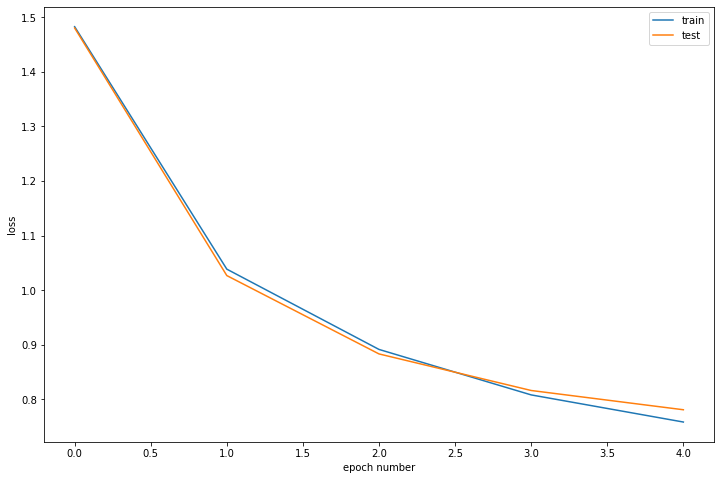

Training loss:  2.2949186335446075
Testing loss:  2.2966477837739827
No. of epochs  1
Training loss:  2.1976434405954928
Testing loss:  2.199554650500485
No. of epochs  2
Training loss:  2.099694170727374
Testing loss:  2.10223761332964
No. of epochs  3
Training loss:  1.9896095194334582
Testing loss:  1.9933919363246408
No. of epochs  4
Training loss:  1.879105772016786
Testing loss:  1.8838949674298238
No. of epochs  5
Test accuracy:  47.839999999999996


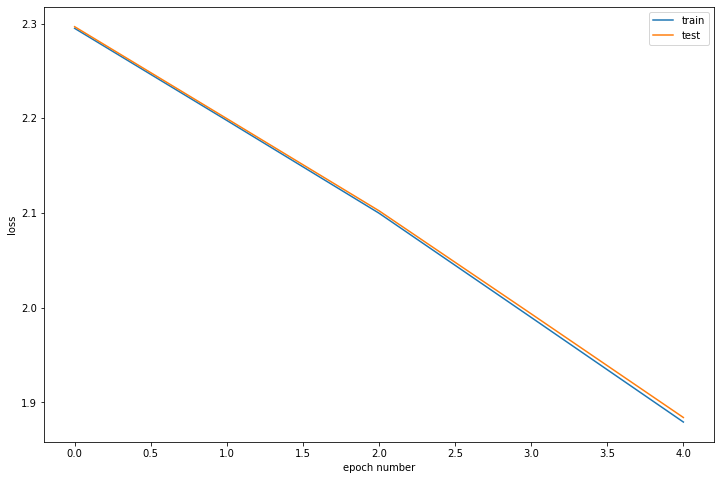

In [219]:
# Make the figures bigger
plt.rcParams['figure.figsize'] = [12, 8]



# A function to train and test the model from the class NeuralNetwork
def train_test(epochs, model):
    epoch_errors_train = []  # training set errors
    epoch_errors_test = []  # testing set errors
    for i in range(epochs):
        total_error_train = 0
        total_error_test = 0
        for x,y,z,e in zip(x_train,y_train, x_test, y_test):
            # Train and test the models
            total_error_train += model.train(x.reshape(1,-1),y.reshape(1,-1))
            total_error_test += model.validate(z.reshape(1, -1), e.reshape(1, -1))
        epoch_errors_train.append(total_error_train/batch_size) # Divide by batch size
        epoch_errors_test.append(total_error_test/batch_size)
        print("Training loss: ", total_error_train/batch_size)
        print("Testing loss: ", total_error_test/batch_size)
        print("No. of epochs ",i+1)
        
    print("Test accuracy: ", model.accuracy(x_test, y_test))
    # Plotting the results
    plt.plot(epoch_errors_train, label='train')
    plt.plot(epoch_errors_test, label='test')
    plt.xlabel('epoch number')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    
    
    
    
    

model = NeuralNetwork(0.001, 128, 64, "sigmoid", "relu")
model2 = NeuralNetwork(0.01, 128, 64, "relu", "sigmoid")
model3 = NeuralNetwork(0.01, 10, 5, "relu", "sigmoid")
model4 = NeuralNetwork(0.001, 10, 5, "sigmoid", "sigmoid")
train_test(5, model)
train_test(5, model2)
train_test(5, model3)
train_test(5, model4)



Training loss:  0.7697985278907334
Testing loss:  0.7592439933087922
No. of epochs  1
Training loss:  0.3835453474702757
Testing loss:  0.4005659996108911
No. of epochs  2
Training loss:  0.31587093414575673
Testing loss:  0.35683186790934474
No. of epochs  3
Training loss:  0.2714034057192482
Testing loss:  0.3295797276565914
No. of epochs  4
Training loss:  0.2397342247979916
Testing loss:  0.31328299717381564
No. of epochs  5
Test accuracy:  91.34


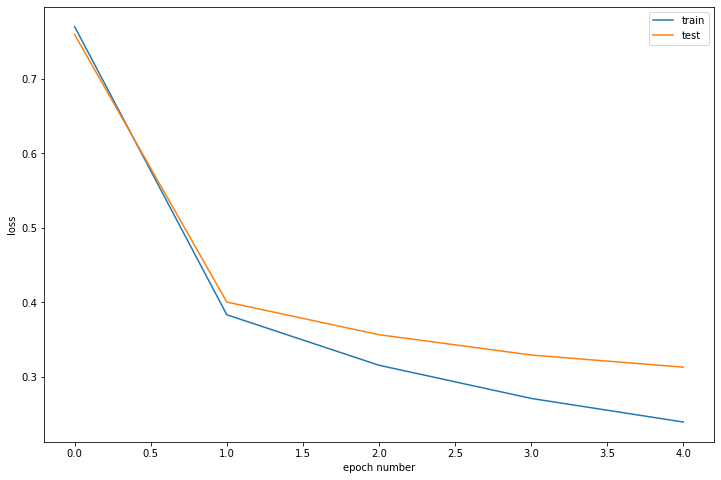

In [218]:
model5 = NeuralNetwork(0.01, 64, 32, "relu", "sigmoid")
train_test(5, model5)